In [1]:
import os
import time
import warnings
import numpy as np
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from typing import List
import argparse
import matplotlib
import matplotlib.pyplot as plt
import datetime
import re
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from torch.utils.data.sampler import Sampler
from torchvision import datasets, transforms


#   Default configuration parameter settings.

In [2]:
parser = argparse.ArgumentParser(
    description='PyTorch Training for Frequency Principle')


parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
parser.add_argument('--optimizer', default='adam',
                    help='optimizer: sgd | adam | nesterov')
parser.add_argument('--epochs', default=100, type=int,
                    metavar='N', help='number of total epochs to run')
parser.add_argument('--training_batch_size',   default=50, type=int,
                    help='the batch size for model (default: 1000)')
parser.add_argument('--training_size',   default=5000, type=int,
                    help='the training size for model (default: 1000)')
parser.add_argument('--test_batch_size',   default=50, type=int,
                    help='the test size for model (default: 10000)')
parser.add_argument('--act_func_name', default='Tanh',
                    help='activation function')
parser.add_argument('--in_channel',   default=3, type=int,
                    help='the input channel for model (default: 3)')
parser.add_argument('--num_classes',   default=10, type=int,
                    help='the output dimension for model (default: 10)')
parser.add_argument('--device',   default='cuda', type=str,
                    help='device used to train (cpu or cuda)')
parser.add_argument('--plot_epoch',   default=1, type=int,
                    help='step size of plotting interval (default: 1000)')
parser.add_argument('--ini_path', type=str,
                    default='')



args, _ = parser.parse_known_args()


#   The storage path of the output file.

In [3]:
def mkdirs(fn):
    """
    Create directories if they don't exist.

    Args:
    fn: The directory path to create.
    """

    if not os.path.isdir(fn):
        os.makedirs(fn)


def create_save_dir(path_ini):
    """
    Create a new directory with the current date and time as its name and return the path of the new directory.

    Args:
    path_ini: The initial path to create the new directory.

    Return:
    The path of the new directory.
    """
    subFolderName = re.sub(r'[^0-9]', '', str(datetime.datetime.now()))
    path = os.path.join(path_ini, subFolderName)
    mkdirs(path)
    mkdirs(os.path.join(path, 'output'))
    return path


args.path = create_save_dir(args.ini_path)
print('save path: %s' % (args.path))


save path: 20240309133818300532


In [4]:
from sklearn.decomposition import PCA
from torchvision.transforms import Resize
import numpy as np

# Resize each image to a one-dimensional vector
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # This will flatten the image
])

# Apply the transformation
train_dataset = datasets.CIFAR10(root="./",
                                train=True,
                                transform=transform,
                                download=True
                                )

# Convert the dataset to a numpy array
train_dataset=Subset(train_dataset,range(args.training_size))
data = np.array([np.array(x[0]) for x in train_dataset])

# Perform PCA
pca = PCA(n_components=2)
pca.fit(data)

# The principal directions are in the 'components_' attribute
principal_directions = pca.components_[0]

# Find all images of class 1
# class_1_images = np.array([np.array(x[0]) for x in train_dataset ])

# Compute the dot product with the principal direction
dot_products = np.dot(data, principal_directions)

Files already downloaded and verified


# Generation of dataloader.

A dataloader is a utility in PyTorch that helps to load and preprocess data for machine learning models. It is used to efficiently load large datasets and feed them to the model in batches during training or inference. 

The `load_data` function defines a dataloader for the CIFAR10 dataset. The function loads the CIFAR10 dataset using the `datasets.CIFAR10` class and applies the `transform` object to the data. It creates a `Subset` object from the training dataset, which selects a subset of the data based on the `training_size` argument. 

The `DataLoader` class is then used to create dataloaders for the training and test datasets. The `train_loader` loads the training data in batches of size `training_batch_size`, while the `test_loader` loads the test data in batches of size `test_batch_size`. The `num_workers` argument specifies the number of subprocesses to use for data loading, while the `shuffle` argument specifies whether to shuffle the data before each epoch. 


This will return two dataloaders: `train_loader` and `test_loader`, which can be used to iterate over the training and test data in batches during training or inference.



In [5]:


def load_data(training_size, training_batch_size, test_batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
        #                     std=[x/255.0 for x in [63.0, 62.1, 66.7]]),
    ])

    train_dataset = datasets.CIFAR10(root="./",
                                    train=True,
                                    transform=transform,
                                    download=True
                                    )

    test_dataset = datasets.CIFAR10(root="./",
                                    train=False,
                                    transform=transform,
                                    download=True)
    

    train_dataset=Subset(train_dataset,range(training_size))

    train_loader = DataLoader(
    train_dataset, batch_size=training_batch_size,  num_workers=2, shuffle=False,drop_last=True, pin_memory=True)

    test_loader = DataLoader(dataset=test_dataset,
                                 batch_size=test_batch_size,
                                 shuffle=False, num_workers=2,drop_last=True, pin_memory=True)

    return train_loader, test_loader




In [6]:
train_loader, test_loader = load_data(
    args.training_size, args.training_batch_size, args.test_batch_size)


train_loader, test_loader=list(train_loader), list(test_loader)


Files already downloaded and verified
Files already downloaded and verified


# How to create a 1D datalodaer

In [7]:
class DealDataset(Dataset):

    def __init__(self, train_X, train_y):
        self.x_data = train_X
        self.y_data = train_y
        self.len = train_X.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

class get_1D_data:
    def __init__(self, args):
        self.args = args

    def get_target_func(self, x):

        return torch.sin(x)+2*torch.sin(3*x)+3*torch.sin(5*x)
    

    def get_inputs(self):

        args = self.args

        bound=1

        for i in range(2):
            if isinstance(args.data_boundary[i], str):
                args.data_boundary[i]=eval(args.data_boundary[i])

        if args.input_dim == 1:

            test_inputs = torch.reshape(torch.linspace(
                bound*args.data_boundary[0], bound*args.data_boundary[1], args.test_size), [-1, 1])
            train_inputs = torch.reshape(torch.linspace(
                args.data_boundary[0], args.data_boundary[1], args.training_size), [-1, 1])
        else:
            test_inputs = (torch.rand(args.test_size, args.input_dim)
                           )*(bound*args.data_boundary[1]-bound*args.data_boundary[0])+bound*args.data_boundary[0]
            train_inputs = torch.rand(args.training_size, args.input_dim) *(args.data_boundary[1]-args.data_boundary[0])+args.data_boundary[0]
        return test_inputs, train_inputs

    def get_data(self):
        test_inputs, train_inputs = self.get_inputs()
        test_targets, train_targets = self.get_target_func(
            test_inputs), self.get_target_func(train_inputs)
        train_dataset = DealDataset(
            train_inputs, train_targets)
        test_dataset = DealDataset(
            test_inputs, test_targets)
        return train_dataset, test_dataset, test_inputs, train_inputs, test_targets, train_targets
def load_data(training_batch_size, test_batch_size, args):

    Get_data = get_1D_data(args)
    train_dataset, test_dataset, _, _, _, _ = Get_data.get_data()
    train_loader = DataLoader(dataset=train_dataset,
                                batch_size=training_batch_size,
                                shuffle=False,drop_last=True)
    test_loader = DataLoader(dataset=test_dataset,
                                batch_size=test_batch_size,
                                shuffle=False,drop_last=True)
    
    return train_loader, test_loader


# Network model

In [8]:
class My_CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes: int = 10, act_layer: nn.Module = nn.ReLU()):
        super(My_CNN, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        conv_layers: List[nn.Module] = []

        conv_layers += [nn.Conv2d(self.in_channels,
                             32, kernel_size=3,stride=1,padding=0), act_layer]
        conv_layers += [nn.Conv2d(32, 64, kernel_size=3,stride=1,padding=0), act_layer]
        conv_layers += [nn.MaxPool2d(kernel_size=(2, 2))]
        self.conv = nn.Sequential(*conv_layers)
        mlp_layers: List[nn.Module] = []
        mlp_layers += [nn.Linear(14*14*64, 400), act_layer]
        mlp_layers += [nn.Linear(400, self.num_classes), nn.Softmax(dim=1)]
        self.mlp = nn.Sequential(*mlp_layers)
        self._initialize_weights()

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        return x
    
    def _initialize_weights(self) -> None:
        for obj in self.modules():
            if isinstance(obj, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(obj.weight.data)




def get_act_func(act_func):
    """
    Get activation function.

    Args:
        act_func (str): activation function name.

    Returns:
        nn.Module: activation function.
    """

    if act_func == 'Tanh':
        return nn.Tanh()
    elif act_func == 'ReLU':
        return nn.ReLU()
    elif act_func == 'Sigmoid':
        return nn.Sigmoid()
    else:
        raise NameError('No such act func!')


act_func = get_act_func(args.act_func_name)

model = My_CNN(args.in_channel, args.num_classes, act_func).to(args.device)
print("The network structure:")
print(model)


The network structure:
My_CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=12544, out_features=400, bias=True)
    (1): Tanh()
    (2): Linear(in_features=400, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)


# One-step training function.

The training data set is denoted as  $S=\{(x_i,y_i)\}_{i=1}^n$, where $x_i\in\mathbb{R}^d$ and $y_i\in \mathbb{R}^{d'}$. For simplicity, we assume an unknown function $y$ satisfying $y(x_i)=y_i$ for $i\in[n]$. The empirical risk reads as
\begin{equation*}
    R_S(\theta)=\frac{1}{n}\sum_{i=1}^n\ell(f(x_i,\theta),y(x_i)),
\end{equation*}
where the loss function $\ell(\cdot,\cdot)$ is differentiable and the derivative of $\ell$ with respect to its first argument is denoted by $\nabla\ell(y,y^*)$. 

For a one-step gradient descent, we have, 

\begin{equation*}
    \theta_{t+1}=\theta_t-\eta\nabla R_S(\theta).
\end{equation*}

In [9]:
def train_one_step(model, optimizer, loss_fn,  train_loader, args):
    """
    It takes in a model, optimizer, loss function, resultsaver, train_loader, and args, and returns the
    average loss and accuracy for the training set

    :param model: the model we're training
    :param optimizer: the optimizer for training model
    :param loss_fn: the loss function
    :param train_loader: the training data loader
    :param args: a dictionary containing all the parameters for the training process
    :return: The average loss and the accuracy
    """
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    device = args.device


    for inputs, targets in train_loader:

        batch_size = inputs.size(0)
        total += batch_size

        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        inputs, targets = torch.autograd.Variable(
            inputs), torch.autograd.Variable(targets)
        outputs = model(inputs)
        loss = loss_fn(torch.log(outputs), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(targets.data).cpu().sum().item()

    acc = 100*correct/total

    return train_loss/total, acc


# One-step test function.

In [10]:
def test(model, loss_fn, test_loader,  args):
    """
    It takes a model, a test_loader, a loss function, and some arguments, and returns the average loss
    and accuracy of the model on the test set.

    :param model: the model
    :param loss_fn: the loss function
    :param test_loader: a DataLoader object
    :param args: a dictionary containing all the parameters for the training process
    :return: The loss and accuracy of the model on the test set.
    """
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    device = args.device
    with torch.no_grad():
        for inputs, targets in test_loader:
            batch_size = inputs.size(0)
            total += batch_size
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = torch.autograd.Variable(
                inputs), torch.autograd.Variable(targets)
            outputs = model(inputs)
            loss = loss_fn(torch.log(outputs), targets)
            train_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs.data, 1)
            correct += predicted.eq(targets.data).cpu().sum().item()
        acc = 100 * correct / total
    return train_loss / total, acc


# Function to obtain model output on the full training set

In [11]:
def val(model, training_loader,  args):
    """
    It takes a model, a test_loader, a loss function, and some arguments, and returns the average loss
    and accuracy of the model on the test set.

    :param model: the model
    :param training_loader: a DataLoader object
    :param args: a dictionary containing all the parameters for the training process
    :return: the outputs of the model on the training set
    """
    model.eval()

    y_pred =[]

    device = args.device
    with torch.no_grad():
        for inputs, targets in training_loader:

            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = torch.autograd.Variable(
                inputs), torch.autograd.Variable(targets)

            outputs = model(inputs)

            y_pred.append(outputs)

    return torch.cat(y_pred)


# Plot the loss value.

In [12]:
def plot_loss(path, loss_train, x_log=False):
    """
    Plot loss.

    Args:
        path (str): path.
        loss_train (list): list of training loss.
        x_log (bool): whether to use log scale for x-axis.

    Returns:
        None.
    """

    plt.figure()
    ax = plt.gca()
    y2 = np.asarray(loss_train)
    plt.plot(y2, 'k-', label='Train')
    plt.xlabel('epoch', fontsize=18)
    ax.tick_params(labelsize=18)
    plt.yscale('log')
    if x_log == False:
        fntmp = os.path.join(path, 'loss.jpg')

    else:
        plt.xscale('log')
        fntmp = os.path.join(path, 'loss_log.jpg')
    plt.tight_layout()
    plt.savefig(fntmp, dpi=300)

    plt.close()


In [13]:
def det_delta_freq_norm(pred, traget, inner_pro, k_lst):
    inner_pro=[]

    for k in k_lst:
        inner_pro.append(np.abs(np.sum((pred-traget)[:,8]*np.exp(-1j*2*np.pi*k*dot_products))/5000)/np.abs(np.sum((traget)[:,8]*np.exp(-1j*2*np.pi*k*dot_products))/5000))

    return inner_pro

# Examination. 

Plot the relative error $e_{\text {low }}$ and $e_{\text {high }}$ at each training epoch.

In [14]:
def SelectPeakIndex(FFT_Data, endpoint=True):

    """
    This function selects the peak index from FFT data.
    
    Args:
    FFT_Data (numpy.ndarray): The FFT data array.
    endpoint (bool): Whether to include endpoints or not. Default is True.
    
    Returns:
    sel_ind (numpy.ndarray): Selected index array with peaks. 
    """
    
    D1 = FFT_Data[1:-1]-FFT_Data[0:-2]
    D2 = FFT_Data[1:-1]-FFT_Data[2:]
    D3 = np.logical_and(D1 > 0, D2 > 0)
    tmp = np.where(D3 == True)
    sel_ind = tmp[0]+1
    if endpoint:
        if FFT_Data[0]-FFT_Data[1] > 0:
            sel_ind = np.concatenate([[0], sel_ind])
        if FFT_Data[-1]-FFT_Data[-2] > 0:
            Last_ind = len(FFT_Data)-1
            sel_ind = np.concatenate([sel_ind, [Last_ind]])
    return sel_ind

# Compute the high and low frequency distribution of targets.

In [15]:


target_list = [target for data, target in train_loader]

targets = torch.cat(target_list)
train_labels = F.one_hot(targets, num_classes=10).detach().cpu().numpy()


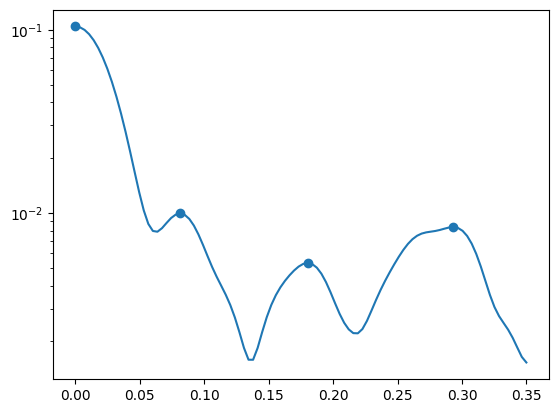

In [16]:

inner_pro=[]

for k in np.linspace(0, 0.35, 100):
    inner_pro.append(np.sum((train_labels)[:,8]*np.exp(-1j*2*np.pi*k*dot_products))/5000)


plt.plot(np.linspace(0, 0.35, 100), np.abs(inner_pro))

plt.scatter(np.linspace(0, 0.35, 100)[SelectPeakIndex(np.abs(inner_pro))], np.abs(inner_pro)[SelectPeakIndex(np.abs(inner_pro))])

plt.yscale('log')

In [17]:
index=SelectPeakIndex(np.abs(inner_pro), endpoint=True)

# Main

In [18]:

loss_fn = nn.NLLLoss()

if args.optimizer == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
elif args.optimizer == 'nesterov':
    optimizer = torch.optim.SGD(
        model.parameters(), lr=args.lr, momentum=0.9, nesterov=True)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# lowdiff = [[] for _ in range(len(filter_dict))]
# highdiff = [[] for _ in range(len(filter_dict))]

relative_error_lst=[]

t0 = time.time()

args.loss_training_lst = []

for epoch in range(args.epochs+1):

    model.train()
    loss, acc = train_one_step(
        model, optimizer, loss_fn, train_loader, args)
    loss_test, acc_test = test(
        model, loss_fn, test_loader, args)
    y_pred=val(model, train_loader, args)
    # index=[0, 17, 27]
    freq_lst=np.linspace(0, 0.35, 100)[index]
    relative_error=det_delta_freq_norm(y_pred.detach().cpu().numpy(), train_labels, dot_products, freq_lst)
    # f_train_low, f_train_high=get_freq_low_high(y_pred.detach().cpu().numpy(), kernel_dict)

    relative_error_lst.append(relative_error)

    # for i in range(len(filter_dict)):

    #     lowdiff[i].append(np.linalg.norm(
    #         f_train_low[i] - f_low[i])/np.linalg.norm(f_low[i]))
    #     highdiff[i].append(np.linalg.norm(
    #         f_train_high[i] - f_high[i])/np.linalg.norm(f_high[i]))

    args.loss_training_lst.append(loss)

    if epoch % args.plot_epoch == 0:
          print("[%d] loss: %.6f acc: %.2f valloss: %.6f valacc: %.2f time: %.2f s" %
                (epoch + 1, loss, acc, loss_test, acc_test, (time.time()-t0)))

    if (epoch+1) % (args.plot_epoch) == 0:
          plot_loss(path=args.path,
                    loss_train=args.loss_training_lst, x_log=True)
          plot_loss(path=args.path,
                    loss_train=args.loss_training_lst, x_log=False)





[1] loss: 1.937019 acc: 31.42 valloss: 1.782159 valacc: 36.84 time: 0.79 s


/tmp/ipykernel_964887/1689078004.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


[2] loss: 1.663026 acc: 43.12 valloss: 1.698823 valacc: 40.34 time: 1.73 s
[3] loss: 1.551083 acc: 46.96 valloss: 1.663552 valacc: 42.00 time: 2.76 s
[4] loss: 1.471068 acc: 48.98 valloss: 1.633509 valacc: 42.94 time: 3.86 s
[5] loss: 1.403742 acc: 51.56 valloss: 1.607927 valacc: 43.62 time: 5.01 s
[6] loss: 1.343210 acc: 53.92 valloss: 1.588491 valacc: 44.69 time: 6.15 s
[7] loss: 1.285859 acc: 56.08 valloss: 1.574305 valacc: 45.57 time: 7.13 s
[8] loss: 1.229814 acc: 58.06 valloss: 1.560591 valacc: 46.26 time: 8.19 s
[9] loss: 1.174262 acc: 60.18 valloss: 1.549128 valacc: 46.76 time: 9.22 s
[10] loss: 1.118774 acc: 62.56 valloss: 1.541922 valacc: 46.90 time: 10.49 s
[11] loss: 1.063740 acc: 64.72 valloss: 1.538482 valacc: 47.15 time: 11.46 s
[12] loss: 1.009604 acc: 66.82 valloss: 1.538181 valacc: 47.42 time: 12.45 s
[13] loss: 0.956558 acc: 68.68 valloss: 1.538945 valacc: 47.77 time: 13.55 s
[14] loss: 0.904754 acc: 70.54 valloss: 1.539283 valacc: 48.16 time: 14.50 s
[15] loss: 0.85

In [19]:
relative_error_lst=np.array(relative_error_lst)


relative_error_lst.shape

(101, 4)

In [20]:
import matplotlib.pyplot as plt
import numpy as np


def format_settings(
        wspace=0.25, 
        hspace=0.4, 
        left=0.12, 
        right=0.9, 
        bottom=0.15, 
        top=0.95,
        fs=12,
        show_dpi=80,
        save_dpi=300,
        lw=1.5,
        ms=5,
        axlw=1.5,
        major_tick_len=5,
        major_tick_width=1.5,
        major_tick_pad=5,
        minor_tick_len=0,
        minor_tick_width=0,
        minor_tick_pad=5,
        ):
    '''
        使用方法：
            fig = plt.figure(figsize=(12, 4), dpi=300)
            format_settings()
            grid = plt.GridSpec(2, 2)
            ax1 = fig.add_subplot(grid[0, 0]) # 左上角图
            ax2 = fig.add_subplot(grid[0, 1]) # 右上角图
            ax3 = fig.add_subplot(grid[:, 0]) # 底部空间合并一张图
        注意：
            以上文字和坐标轴粗细适用于figsize长度为12的情形，宽度可调。
            若要调整figsize长度，需要相应调整以上文字和坐标轴粗细。
    '''
    # 设置子图线宽
    plt.rcParams['lines.linewidth'] = lw
    
    # 子图点大小
    plt.rcParams['lines.markersize'] = ms
    
    # 子图间距与位置  w:左右 h:上下
    plt.subplots_adjust(wspace=wspace, hspace=hspace, left=left, right=right, bottom=bottom, top=top)

    # 字体大小
    plt.rcParams['font.size'] = fs
    plt.rcParams['axes.labelsize'] = fs
    plt.rcParams['axes.titlesize'] = fs
    plt.rcParams['xtick.labelsize'] =fs
    plt.rcParams['ytick.labelsize'] = fs
    plt.rcParams['legend.fontsize'] = fs
    # 子图坐标轴宽度
    plt.rcParams['axes.linewidth'] = axlw
    # 子图坐标轴可见性
    plt.rcParams['axes.spines.top'] = True
    plt.rcParams['axes.spines.right'] = True
    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.spines.bottom'] = True

    # 子图坐标轴刻度宽度
    plt.rcParams['xtick.major.width'] = major_tick_width
    plt.rcParams['ytick.major.width'] = major_tick_width
    plt.rcParams['xtick.minor.width'] = minor_tick_width
    plt.rcParams['ytick.minor.width'] = minor_tick_width
    # 子图坐标轴刻度长度
    plt.rcParams['xtick.major.size'] = major_tick_len
    plt.rcParams['ytick.major.size'] = major_tick_len
    plt.rcParams['xtick.minor.size'] = minor_tick_len
    plt.rcParams['ytick.minor.size'] = minor_tick_len
    # 子图坐标轴刻度标签位置
    plt.rcParams['xtick.major.pad'] = major_tick_pad
    plt.rcParams['ytick.major.pad'] = major_tick_pad
    plt.rcParams['xtick.minor.pad'] = minor_tick_pad
    plt.rcParams['ytick.minor.pad'] = minor_tick_pad
    
    # 子图坐标轴刻度标签位置
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    # 子图坐标轴刻度标签位置
    plt.rcParams['xtick.top'] = False 
    plt.rcParams['ytick.right'] = False
    # 子图坐标轴刻度标签位置
    plt.rcParams['xtick.minor.visible'] = False
    plt.rcParams['ytick.minor.visible'] = False
    # 子图坐标轴刻度标签位置
    plt.rcParams['legend.frameon'] = False
    # 子图坐标轴刻度标签位置
    plt.rcParams['figure.dpi'] = show_dpi
    # 子图坐标轴刻度标签位置
    plt.rcParams['savefig.dpi'] = save_dpi


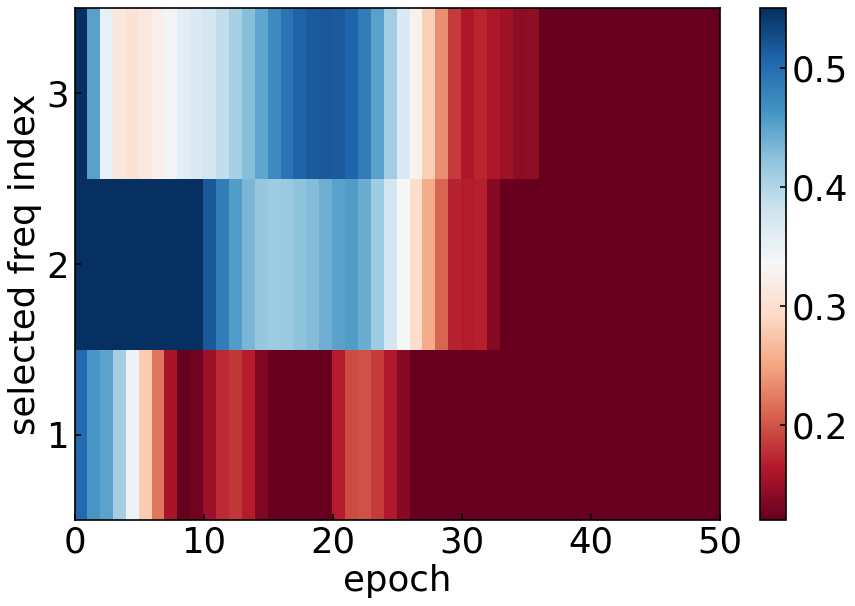

In [25]:

plt.figure(figsize=(12, 8))
format_settings(left=0.15, right=0.99, bottom=0.15, fs=32
        )
# plt.title('freq with filter {:.02f}'.format(filter))

# tmp = np.stack([lowdiff, highdiff])
index=[0,1,2]
plt.pcolor(relative_error_lst.T[index,:50], cmap='RdBu', vmin=0.12, vmax=0.55)
cbar=plt.colorbar()
cbar.set_ticks([0.2,0.3,0.4, 0.5])
# plt.yticks([0.6, 1.6], ('low freq', 'high freq'), rotation='vertical')
plt.xlabel('epoch')
plt.ylabel('selected freq index')
plt.yticks(np.arange(0.5, 3.5, 1), [1,2,3])
plt.savefig('./f-principle_nd_projection_heat.png', dpi=300)
# plt.show()


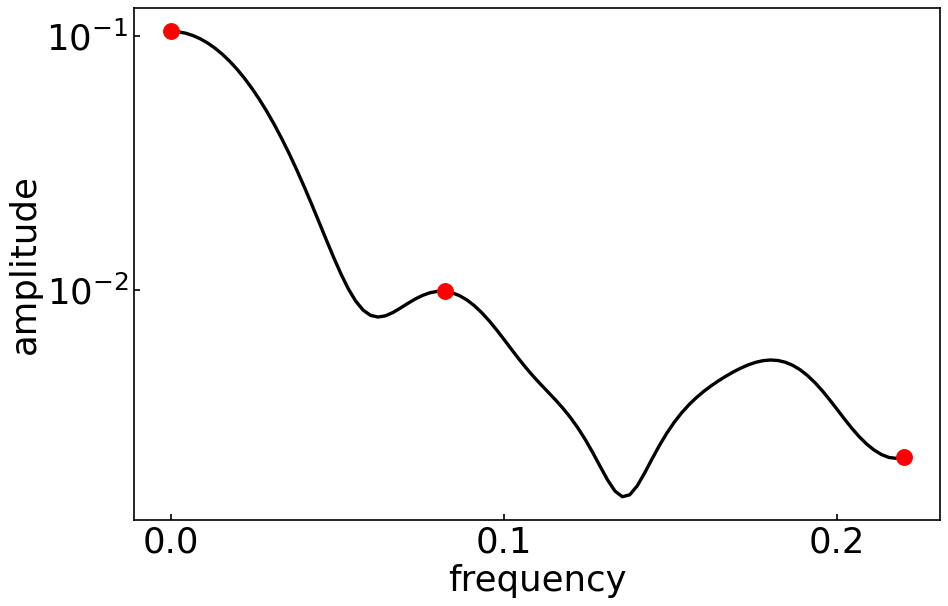

In [26]:

inner_pro=[]

for k in np.linspace(0, 0.22, 100):
    inner_pro.append(np.sum((train_labels)[:,8]*np.exp(-1j*2*np.pi*k*dot_products))/5000)


plt.figure(figsize=(12, 8))
format_settings(left=0.15, right=0.99, bottom=0.15, fs=32, lw=3
        )
plt.plot(np.linspace(0, 0.22, 100), np.abs(inner_pro), c='black')
index=[0,1, 2]
plt.scatter(np.linspace(0, 0.22, 100)[SelectPeakIndex(np.abs(inner_pro))][index], np.abs(inner_pro)[SelectPeakIndex(np.abs(inner_pro))][index], s=200, c='red', zorder=10)
plt.xticks([0, 0.1, 0.2])
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.yscale('log')
plt.savefig('./f-principle_nd_projection_freq.png', dpi=300)